# Computer Vision Coursework Submission (IN3060)

**Alessandro Suarez, (210018826) - UG:**


# Notebook Setup
In this section you should include all the code cells required to test your coursework submission. Specifically:

### Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Define Local Path

In the next cell you should assign to the variable `GOOGLE_DRIVE_PATH_AFTER_MYDRIVE` the relative path of this folder in your Google Drive.

**IMPORTANT:** you have to make sure that **all the files required to test your functions are loaded using this variable** (as was the case for all lab tutorials). In other words, do not use in the notebook any absolute paths. This will ensure that the markers can run your functions. Also, **do not use** the magic command `%cd` to change directory.



In [2]:
import os

# TODO: Fill in the Google Drive path where you uploaded the CW_folder_UG
# Example: GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Computer Vision/CW_folder_UG'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '/content/drive/MyDrive/Colab Notebooks/CW_Folder_UG'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['.DS_Store', 'Code', 'Models', 'CW_Dataset', 'Personal_Dataset', 'test_functions.ipynb']


### Load packages

In the next cell you should load all the packages required to test your functions.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from joblib import dump, load
import cv2
import torch
from torch import nn
from torchvision import models, transforms
from PIL import Image, ImageEnhance
from skimage import color, img_as_ubyte
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans

### Load models

In the next cell you should load all your trained models for easier testing of your functions. Avoid to load them within `MaskDetection` to avoid having to reload them each time.

In [4]:
# paths set where the models are saved
kmeans_model_path = os.path.join(GOOGLE_DRIVE_PATH, 'Models', 'SIFT_KMeans_model.pkl')
svm_model_path = os.path.join(GOOGLE_DRIVE_PATH, 'Models', 'SIFT_SVM_model.pkl')
mlp_model_path = os.path.join(GOOGLE_DRIVE_PATH, 'Models', 'HOG_MLP_model.pkl')
cnn_model_path = os.path.join(GOOGLE_DRIVE_PATH, 'Models', 'CNN.pth')

# Load the models
kmeans = load(kmeans_model_path)
sift_svm = load(svm_model_path)
hog_mlp = load(mlp_model_path)

# Load CNN
def load_cnn_model(model_path, device):
    # Initialize the architecture first
    model = models.resnet18(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 3)  # Adjust based on the number of classes
    # Load the state dictionary
    model.load_state_dict(torch.load(model_path, map_location=device))
    # Move the model to the specified device
    model = model.to(device)
    # Set the model to evaluation mode
    model.eval()

    return model

# Load the CNN model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model = load_cnn_model(cnn_model_path, device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


# Test MaskDetection

This section should allow a quick test of the `MaskDetection` function. First, add cells with the code needed to load the necessary subroutines to make `MaskDetection` work.

In [5]:
pass

In [6]:
# Load the dataset
def load_dataset(root_dir):
    img_dir = os.path.join(root_dir, 'images')
    labels_dir = os.path.join(root_dir, 'labels')
    img_names = [img_name for img_name in os.listdir(img_dir) if img_name.endswith(('.jpg', '.jpeg', '.png'))]
    images, labels = [], []
    for img_name in img_names:
        img_path = os.path.join(img_dir, img_name)
        label_path = os.path.join(labels_dir, os.path.splitext(img_name)[0] + '.txt')
        image = Image.open(img_path).convert('RGB').resize((224, 224), Image.Resampling.LANCZOS)
        label = int(open(label_path, 'r').read().strip())
        images.append(image)
        labels.append(label)
    return images, labels


# Image enhancement and augmentation
def process_images(images):
    def enhance_image(image):
        image = ImageEnhance.Contrast(image).enhance(1.8)
        image = ImageEnhance.Brightness(image).enhance(1.2)
        return image
    images = [enhance_image(image) for image in images]
    return images

# Normalize features
def normalize_features(features):
    scaler = StandardScaler()
    return scaler.fit_transform(features)

# Extract HOG features
def extract_hog_features(images):
    hog_features = []
    for image in images:
        gray_image = color.rgb2gray(np.array(image))
        features = hog(gray_image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=False, multichannel=False)
        hog_features.append(features)
    return np.array(hog_features)


# Extract SIFT features
def extract_sift_features(images):
    sift = cv2.SIFT_create()
    des_list = []
    for image in images:
        img_np = np.array(image)
        img_gray = img_as_ubyte(color.rgb2gray(img_np))
        kp, des = sift.detectAndCompute(img_gray, None)
        if des is not None:
            des_list.append(des)
        else:
            des_list.append(np.zeros((1, 128)))
    return des_list

# Convert descriptors into histograms of codewords for each image
def get_feature_histogram(des_list, kmeans):
    hist_list = []
    for des in des_list:
        hist = np.zeros(kmeans.n_clusters)
        idx = kmeans.predict(des)
        for j in idx:
            hist[j] += 1 / len(des)  # Normalizing
        hist_list.append(hist)
    return np.vstack(hist_list)

# Normalized images for CNN
def prepare_for_cnn(images, device):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Example normalization
    ])
    tensor_images = [transform(image).unsqueeze(0) for image in images]
    tensor_images = torch.cat(tensor_images).to(device)
    return tensor_images

test_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset', 'test')

Then, make a call to the `MaskDetection` function to see what results it produces. You must also indicate the syntax needed to test your different models.

Loaded 458 images.
Processed 458 images.


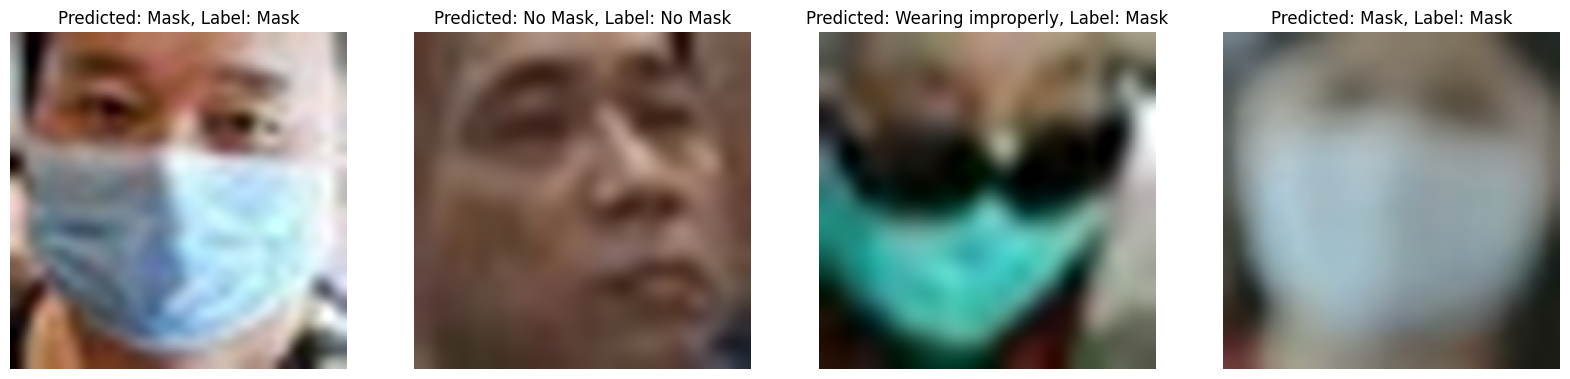

In [22]:
def MaskDetection(path_to_testset, model_type):
    # Load and preprocess test images
    test_images, test_labels = load_dataset(path_to_testset)
    processed_images = process_images(test_images)
    print(f"Loaded {len(test_images)} images.")
    print(f"Processed {len(processed_images)} images.")

    predictions = []
    if model_type == 'sift_svm':
        sift_features = extract_sift_features(processed_images)
        features = get_feature_histogram(sift_features, kmeans)
        predictions = sift_svm.predict(features)
    elif model_type == 'hog_mlp':
        hog_features = extract_hog_features(processed_images)
        features = normalize_features(hog_features)
        predictions = hog_mlp.predict(features)
    elif model_type == 'cnn_model':
        cnn_inputs = prepare_for_cnn(processed_images, device)
        cnn_model.eval()
        with torch.no_grad():
            outputs = cnn_model(cnn_inputs)
            _, predicted = torch.max(outputs, 1)
            predictions = predicted.cpu().numpy()

    # Validate number of images and predictions
    num_images_to_show = min(len(test_images), len(predictions), 4)
    if num_images_to_show == 0:
        print("No images or predictions to show.")
        return predictions

    # Define class names
    class_names = {0: 'No Mask', 1: 'Mask', 2: 'Wearing improperly'}

    # Display results
    fig, axes = plt.subplots(1, num_images_to_show, figsize=(num_images_to_show * 5, 5))
    for i in range(num_images_to_show):
        axes[i].imshow(np.array(test_images[i]), cmap='gray')
        predicted_label = class_names[predictions[i]] if predictions[i] in class_names else 'Unknown'
        true_label = class_names[test_labels[i]] if test_labels[i] in class_names else 'Unknown'
        axes[i].set_title(f"Predicted: {predicted_label}, Label: {true_label}")
        axes[i].axis('off')
    plt.show()

    return predictions

path_to_testset = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset', 'test')
model_type = 'cnn_model'  # To test other models 'sift_svm', 'hog_mlp', or 'cnn_model'
predictions = MaskDetection(path_to_testset, model_type)

# Test MaskDetection in the wild

This section should allow a quick test of the `MaskDetection` on your `Personal_Dataset`.

In [8]:
# Load the personal dataset
def load_dataset(personal_dataset_dir):
    img_dir = os.path.join(personal_dataset_dir, 'images')
    labels_dir = os.path.join(personal_dataset_dir, 'labels')
    img_names = [img_name for img_name in os.listdir(img_dir) if img_name.endswith(('.jpg', '.jpeg', '.png'))]
    images, labels = [], []
    for img_name in img_names:
        img_path = os.path.join(img_dir, img_name)
        label_path = os.path.join(labels_dir, os.path.splitext(img_name)[0] + '.txt')
        image = Image.open(img_path).convert('RGB').resize((224, 224), Image.Resampling.LANCZOS)
        label = int(open(label_path, 'r').read().strip())
        images.append(image)
        labels.append(label)
    return images, labels


# Image enhancement and augmentation
def process_images(images):
    def enhance_image(image):
        image = ImageEnhance.Contrast(image).enhance(1.8)
        image = ImageEnhance.Brightness(image).enhance(1.2)
        return image
    images = [enhance_image(image) for image in images]
    return images

# Normalize features
def normalize_features(features):
    scaler = StandardScaler()
    return scaler.fit_transform(features)

# Extract HOG features
def extract_hog_features(images):
    hog_features = []
    for image in images:
        gray_image = color.rgb2gray(np.array(image))
        features = hog(gray_image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=False, multichannel=False)
        hog_features.append(features)
    return np.array(hog_features)


# Extract SIFT features
def extract_sift_features(images):
    sift = cv2.SIFT_create()
    des_list = []
    for image in images:
        img_np = np.array(image)
        img_gray = img_as_ubyte(color.rgb2gray(img_np))
        kp, des = sift.detectAndCompute(img_gray, None)
        if des is not None:
            des_list.append(des)
        else:
            des_list.append(np.zeros((1, 128)))
    return des_list

# Convert descriptors into histograms of codewords for each image
def get_feature_histogram(des_list, kmeans):
    hist_list = []
    for des in des_list:
        hist = np.zeros(kmeans.n_clusters)
        idx = kmeans.predict(des)
        for j in idx:
            hist[j] += 1 / len(des)  # Normalizing
        hist_list.append(hist)
    return np.vstack(hist_list)

# Normalized images for CNN
def prepare_for_cnn(images, device):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Example normalization
    ])
    tensor_images = [transform(image).unsqueeze(0) for image in images]
    tensor_images = torch.cat(tensor_images).to(device)
    return tensor_images

personal_dataset_dir = os.path.join(GOOGLE_DRIVE_PATH, 'Personal_Dataset', 'test')

Loaded 24 images.
Processed 24 images.


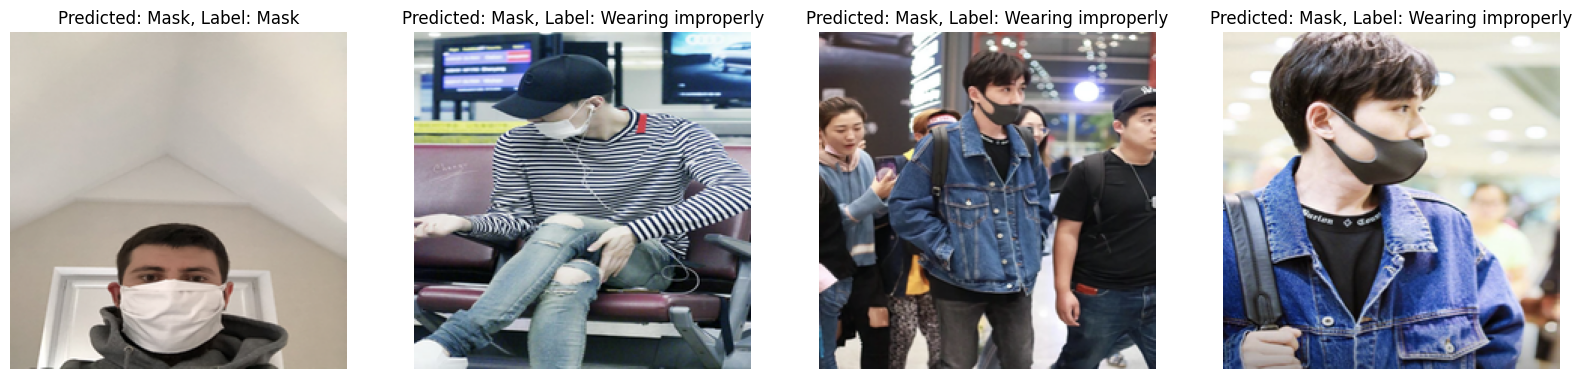

In [21]:
def MaskDetection(personal_dataset_dir, model_type):
    # Load and preprocess test images
    test_images, test_labels = load_dataset(personal_dataset_dir)
    processed_images = process_images(test_images)
    print(f"Loaded {len(test_images)} images.")
    print(f"Processed {len(processed_images)} images.")

    predictions = []
    if model_type == 'sift_svm':
        sift_features = extract_sift_features(processed_images)
        features = get_feature_histogram(sift_features, kmeans)
        predictions = sift_svm.predict(features)
    elif model_type == 'hog_mlp':
        hog_features = extract_hog_features(processed_images)
        features = normalize_features(hog_features)
        predictions = hog_mlp.predict(features)
        print(f"Extracted HOG features from {len(hog_features)} images.")
        print(f"Normalized features for {len(features)} images.")
        print(f"Normalized features for {len(features)} images.")
    elif model_type == 'cnn_model':
        cnn_inputs = prepare_for_cnn(processed_images, device)
        cnn_model.eval()
        with torch.no_grad():
            outputs = cnn_model(cnn_inputs)
            _, predicted = torch.max(outputs, 1)
            predictions = predicted.cpu().numpy()

    # Validate number of images and predictions
    num_images_to_show = min(len(test_images), len(predictions), 4)
    if num_images_to_show == 0:
        print("No images or predictions to show.")
        return predictions

    # Define class names
    class_names = {0: 'No Mask', 1: 'Mask', 2: 'Wearing improperly'}

    # Display results
    fig, axes = plt.subplots(1, num_images_to_show, figsize=(num_images_to_show * 5, 5))
    for i in range(num_images_to_show):
        axes[i].imshow(np.array(test_images[i]), cmap='gray')
        predicted_label = class_names[predictions[i]] if predictions[i] in class_names else 'Unknown'
        true_label = class_names[test_labels[i]] if test_labels[i] in class_names else 'Unknown'
        axes[i].set_title(f"Predicted: {predicted_label}, Label: {true_label}")
        axes[i].axis('off')
    plt.show()

personal_dataset_dir = os.path.join(GOOGLE_DRIVE_PATH, 'Personal_Dataset', 'test')
model_type = 'cnn_model'  # To test other models 'sift_svm', 'hog_mlp', or 'cnn_model'
predictions = MaskDetection(personal_dataset_dir, model_type)


